In [1]:
import os, sys, glob, shutil, json
import cv2

from PIL import Image
import numpy as np
import pandas as pd

from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True
import torch.nn as nn
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms
import torchvision.models as models

In [14]:
print(torch.__version__)
print(torch.cuda.is_available())

device = torch.device('cuda')

1.7.0+cu101
True


# EDA

In [15]:
# 统计train, val, test数据集的个数
def data_summary():
    train_list = glob.glob('../input/mchar_train/*.png')
    val_list = glob.glob('../input/mchar_val/*.png')
    test_list = glob.glob('../input/mchar_test_a/*.png')
    print('train image counts: %d'%len(train_list))
    print('val image counts: %d'%len(val_list))
    print('test image counts: %d'%len(test_list))

data_summary()

train image counts: 30000
val image counts: 10000
test image counts: 40000


In [16]:
# 看train数据集第一张的信息，长宽高等
train_json = json.load(open('../input/mchar_train.json'))
print(train_json['000000.png'])

{'height': [219, 219], 'label': [1, 9], 'left': [246, 323], 'top': [77, 81], 'width': [81, 96]}


In [17]:
# 看需要输出文件的信息
def look_submit():
    df = pd.read_csv('../input/mchar_sample_submit_A.csv', sep=',')
    print(df.head(5))

look_submit()

    file_name  file_code
0  000000.png          0
1  000001.png          0
2  000002.png          0
3  000003.png          0
4  000004.png          0


In [18]:
#统计图片分别含有数字的个数
def label_summary():
    marks = json.load(open('../input/mchar_train.json', 'r'))

    dicts = {}
    for img, mark in marks.items():
        if len(mark['label']) not in dicts:
            dicts[len(mark['label'])] = 0
        dicts[len(mark['label'])] += 1

    dicts = sorted(dicts.items(), key=lambda x: x[0])
    for k, v in dicts:
        print('%d个数字的图片数目: %d' % (k, v))


label_summary()

1个数字的图片数目: 4636
2个数字的图片数目: 16262
3个数字的图片数目: 7813
4个数字的图片数目: 1280
5个数字的图片数目: 8
6个数字的图片数目: 1


# load data

In [2]:
fixed_length_str = 5
BATCH_SIZE = 100

class SVHNDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label 
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None

    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        if self.img_label == None:
            return img
        else:
            # 原始SVHN中类别10为填充的数字X, 最多字符为5
            lbl = np.array(self.img_label[index], dtype=np.int)
            lbl = list(lbl)  + (fixed_length_str - len(lbl)) * [10]
            
            return img, torch.from_numpy(np.array(lbl[:fixed_length_str]))

    def __len__(self):
        return len(self.img_path)


train_path = glob.glob('../input/mchar_train/*.png')
train_path.sort()
train_json = json.load(open('../input/mchar_train.json'))
train_label = [train_json[x]['label'] for x in train_json]

val_path = glob.glob('../input/mchar_val/*.png')
val_path.sort()
val_json = json.load(open('../input/mchar_val.json'))
val_label = [val_json[x]['label'] for x in val_json]

train_loader = torch.utils.data.DataLoader(
        SVHNDataset(train_path, train_label,
                   transforms.Compose([
                       transforms.Resize((64, 128)),
                       transforms.ColorJitter(0.3, 0.3, 0.2),
                       transforms.RandomRotation(5),
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])), 
    batch_size=BATCH_SIZE, # 每批样本个数
    shuffle=True, # 是否打乱顺序
    num_workers=10, # 读取的线程个数
)

    
val_loader = torch.utils.data.DataLoader(
    SVHNDataset(val_path, val_label,
                    transforms.Compose([
                       transforms.Resize((64, 128)),
                    #    transforms.ColorJitter(0.3, 0.3, 0.2),
                    #    transforms.RandomRotation(5),
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])), 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=10, 
)

# model

In [3]:
# 定义模型
class SVHN_Model1(nn.Module):
    def __init__(self):
        super(SVHN_Model1, self).__init__()
        # CNN提取特征模块
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU(), 
            nn.Dropout(0.25),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU(), 
            nn.Dropout(0.25),
            nn.MaxPool2d(2),
        )
        # 
        self.fc1 = nn.Linear(32*3*7, 11)
        self.fc2 = nn.Linear(32*3*7, 11)
        self.fc3 = nn.Linear(32*3*7, 11)
        self.fc4 = nn.Linear(32*3*7, 11)
        self.fc5 = nn.Linear(32*3*7, 11)
    
    def forward(self, img):        
        feat = self.cnn(img)
        feat = feat.view(feat.shape[0], -1)
        c1 = self.fc1(feat)
        c2 = self.fc2(feat)
        c3 = self.fc3(feat)
        c4 = self.fc4(feat)
        c5 = self.fc5(feat)
        return c1, c2, c3, c4, c5

 
# model = SVHN_Model1()
model = SVHN_Model1().cuda()
# 损失函数
criterion = nn.CrossEntropyLoss(size_average=False)
# 优化器
optimizer = torch.optim.Adam(model.parameters(), 0.001)
best_loss = 1000.0


# def train(train_loader, model, criterion, optimizer, epoch):
#     # 切换模型为训练模式
#     model.train()
#     train_loss = []

#     for data in tqdm(train_loader):

#         data.cuda()

#         c0, c1, c2, c3, c4 = model(data[0])
#         loss = criterion(c0, data[1][:, 0]) + \
#                 criterion(c1, data[1][:, 1]) + \
#                 criterion(c2, data[1][:, 2]) + \
#                 criterion(c3, data[1][:, 3]) + \
#                 criterion(c4, data[1][:, 4])
#         loss /= fixed_length_str
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         train_loss.append(loss.item())
#     return np.mean(train_loss)
def train(train_loader, model, criterion, optimizer, epoch):
    # 切换模型为训练模式
    model.train()
    train_loss = []

    for step, (x, y) in enumerate(train_loader):
        x = x.cuda()
        y = y.cuda()

        c0, c1, c2, c3, c4 = model(x)
        loss = criterion(c0, y[:, 0]) + \
                criterion(c1, y[:, 1]) + \
                criterion(c2, y[:, 2]) + \
                criterion(c3, y[:, 3]) + \
                criterion(c4, y[:, 4])
        loss /= fixed_length_str
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
    return np.mean(train_loss)

# def validate(val_loader, model, criterion):
#     # 切换模型为预测模型
#     model.eval()
#     val_loss = []

#     # 不记录模型梯度信息
#     with torch.no_grad():
#         for data in val_loader:
#             data.cuda()
#             c0, c1, c2, c3, c4 = model(data[0])
#             loss = criterion(c0, data[1][:, 0]) + \
#                     criterion(c1, data[1][:, 1]) + \
#                     criterion(c2, data[1][:, 2]) + \
#                     criterion(c3, data[1][:, 3]) + \
#                     criterion(c4, data[1][:, 4])
#             loss /= fixed_length_str
#             val_loss.append(loss.item())
#     return np.mean(val_loss)
def validate(val_loader, model, criterion):
    # 切换模型为预测模型
    model.eval()
    val_loss = []

    # 不记录模型梯度信息
    with torch.no_grad():
        for step, (x, y) in enumerate(val_loader):
            x = x.cuda()
            y = y.cuda()

            c0, c1, c2, c3, c4 = model(x)
            loss = criterion(c0, y[:, 0]) + \
                    criterion(c1, y[:, 1]) + \
                    criterion(c2, y[:, 2]) + \
                    criterion(c3, y[:, 3]) + \
                    criterion(c4, y[:, 4])
            loss /= fixed_length_str
            val_loss.append(loss.item())
    return np.mean(val_loss)



train_loss_plot = list()
val_loss_plot = list()

/usr/local/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Train

In [4]:
for epoch in tqdm(range(20)):
    # print('\nEpoch: ', epoch)

    train_loss = train(train_loader, model, criterion, optimizer, epoch)
    val_loss = validate(val_loader, model, criterion)
    
    # 记录下验证集精度
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), './model.pt')
        
    train_loss_plot.append(train_loss)
    val_loss_plot.append(val_loss)

print("validation min loss:", best_loss)

100%|██████████| 20/20 [02:44<00:00,  8.21s/it]


# plot loss

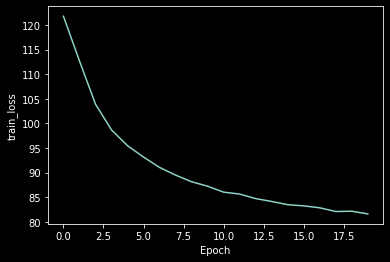

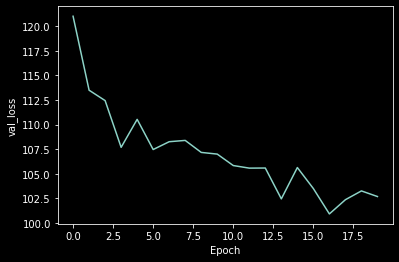

In [5]:
plt.plot(train_loss_plot)
plt.xlabel("Epoch")
plt.ylabel("train_loss")
plt.show()

plt.plot(val_loss_plot)
plt.xlabel("Epoch")
plt.ylabel("val_loss")
plt.show()

# test data

In [153]:
test_path = glob.glob('../input/mchar_test_a/*.png')
test_path.sort()
test_label = None

test_loader = torch.utils.data.DataLoader(
        SVHNDataset(test_path, test_label,
                   transforms.Compose([
                       transforms.Resize((64, 128)),
                    #    transforms.ColorJitter(0.3, 0.3, 0.2),
                    #    transforms.RandomRotation(5),
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])), 
    batch_size=BATCH_SIZE, # 每批样本个数
    shuffle=False, # 是否打乱顺序
    num_workers=10, # 读取的线程个数
)

In [154]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [155]:
def predict(test_loader, model, tta=10):
    model.eval()
    test_pred_tta = None
    # TTA 次数
    for _ in range(tta):
        test_pred = []

        with torch.no_grad():
            for step, (x, y) in enumerate(test_loader):
                x = x.cuda()
                y = y.cuda()
                c0, c1, c2, c3, c4 = model(x)
                output = np.concatenate([c0.data.numpy(), c1.data.numpy(),
                   c2.data.numpy(), c3.data.numpy(),
                   c4.data.numpy()], axis=1)
                test_pred.append(output)
        
        test_pred = np.vstack(test_pred)
        if test_pred_tta is None:
            test_pred_tta = test_pred
        else:
            test_pred_tta += test_pred
    
    return test_pred_tta

test_pred_tta = predict(test_loader, model, tta=10)

In [156]:
predict = torch.from_numpy(test_pred_tta).view(40000, fixed_length_str, -1)

In [157]:
import torch.nn.functional as F

predict_softmax = F.softmax(predict, dim=2)
predict_label = predict_softmax.argmax(dim=2)

In [158]:
def concat(*kw):
    result = ""
    for i in kw:
        result += str(i)
    return int(result)

submit = list()
for label in predict_label.numpy(): 
     submit.append(concat(*label[label<10]))

In [159]:
df_submit = pd.read_csv('../input/mchar_sample_submit_A.csv')
df_submit['file_code'] = submit
df_submit.to_csv('submit.csv', index=None)